# Nonlinear Klein-Gordon (General): $u_{tt} - u_{rr} + m^{2}u + G'(u) = 0$
#### where $G'(u) = |u|^{p-1}u$, subbing in $v = ur$ and $m=1$:
## $v_{tt} - v_{xx} + r^{1-p}|v|^{p-1}v = 0$

## 1. Explicit Method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

%matplotlib widget
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D

import heat_equations as PDE

#### INITIAL & BOUNDARY CONDITIONS:

In [2]:
# ! - Initial Condition Function.  Emits an array with small sine wave for this example
def f_u_0_x(input_array):
    length = len(input_array)
    amplitude = max(input_array) / 10  # 1/10th as tall
    width = length // 10  # 1/10th as wide
    start = length // 3  # 1/3 through the list
    
    half_sine_wave = np.zeros(length)
    
    for i in range(start, start + width):
        if i < length:
            value = amplitude * np.sin((i - start) * np.pi / width)
            if value > 0:
                half_sine_wave[i] = value
            else:
                half_sine_wave[i] = 0
    
    return half_sine_wave

# Boundary Condition Functions (Dirchelet)
def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

In [3]:
def nonlinear_kg_timestep(u_line,u_line_previous,m,dt,dx,p):
    '''
    Takes in:
    -u_line: a 1D array
    -u_line_previous: a 1D array
    -m: a space index 
    -dt: time step
    -dx: x step
    -p: the exponent used for G'(u)
    
    ***Add notes here about derivation from the centered difference from each side of the equation***
    
    Returns:
    -u, an array containing solutions for that timestep
    
    '''
    x = m * dx
    return ((dt**2/dx**2) * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) - 
            dt**2 * x**(1-p) * abs(u_line[m])**(p-1) * u_line[m] + 
            2*u_line[m] - u_line_previous[m])

In [4]:
# -- User Defined - IC and Boundary condition functions determined at start of notebook
L = 1
t_max = 1

p = 3

# m = 1

dx = .002
dt = .002

# -- Create a stability check
if dx/dt < 1:
    raise Exception(f"Entered dt is outside of stability range.  Please enter a smaller step size.")

# -- Calculated
Nx = int(L/dx) 
Nt = int(t_max/dt)

x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

# -- Create solution data holder
U = []

# -- Append initial conditions (t = 0) and boundary conditions (x = 0, x = L)
u_t_x_0 = f_u_0_x(x_grid)

u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U.append(u_t_x_0)

u_previous = U[-1]

for j in range(len(t_grid)):
    u_t_x = []
    
    u_line = U[-1]
    
    for m in range(1,len(x_grid)-1):
        u = nonlinear_kg_timestep(u_line,u_previous,m,dt,dx,p)
        # Append this value to the time step line
        u_t_x.append(u)
        
    u_previous = u_line

    # Append the first and last value with boundary conditions (0 in this case)
    u_t_x.insert(0,f_u_t_0(0))
    u_t_x.append(f_u_t_L(0))

    # Now append the full solutions matrix
    U.append(u_t_x)

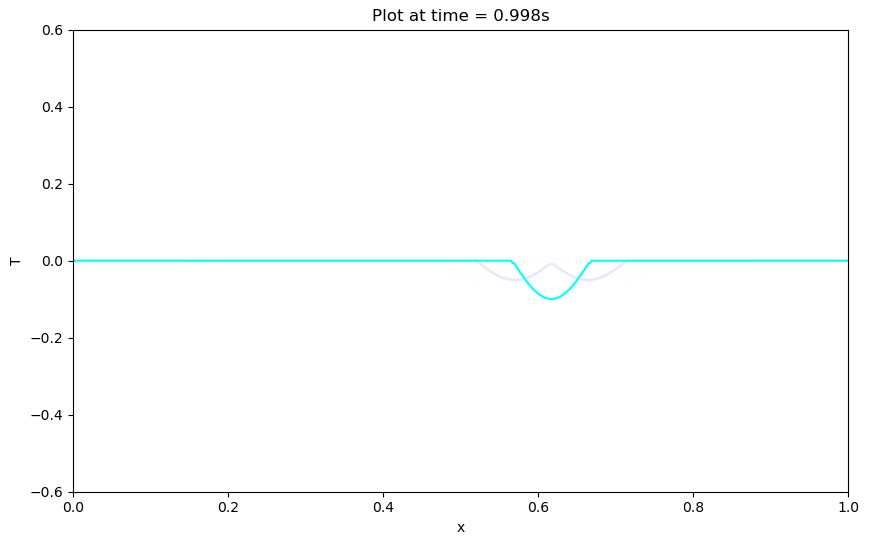

In [5]:
steps = 20
t_min_plot = 0             # default = 0
t_max_plot = t_max          # default = len(U_7)
x_min_plot = 0            # default = 0
x_max_plot = L           # default = t_max
PDE.PDE_plotter_1D(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .1)

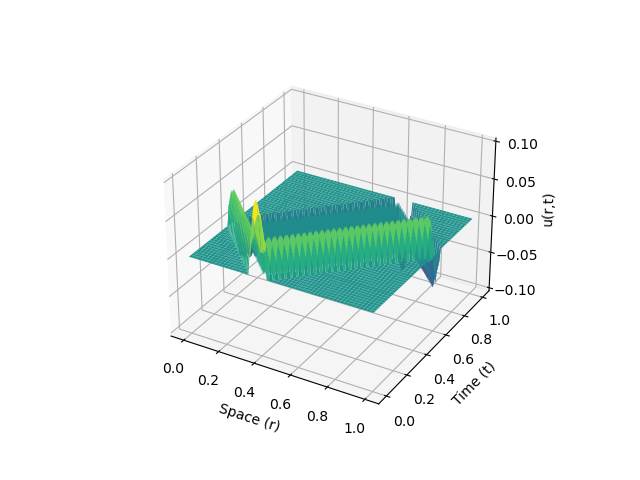

In [6]:
R, T = np.meshgrid(x_grid, t_grid)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, np.array(U[:-1]), cmap='viridis')
ax.set_xlabel('Space (r)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('u(r,t)')
plt.show()

## 2. Other Methods to Solve
Using a modified Crank-Nicholson: Needs work!

In [7]:
# Parameters
L = 1  # length of the spatial domain
T = 1   # total time
m = 1.0   # mass term
N_r = 100  # number of spatial steps
N_t = 100  # number of time steps
delta_r = L / N_r
delta_t = T / N_t

p = 3

# Discretized space and time
r = np.linspace(0, L, N_r+1)
t = np.linspace(0, T, N_t+1)

# Initial conditions
u = np.zeros((N_t+1, N_r+1))
u[0, :] = f_u_0_x(r)  # initial condition at t=0

# Placeholder for G'(u)
def G_prime(u):
    return abs(u)**(p-1)*u  # example nonlinear term

# Time-stepping loop
for n in range(1, N_t):
    # Coefficient matrix and RHS vector
    A = diags([1, -2, 1], [-1, 0, 1], shape=(N_r+1, N_r+1)).toarray()
    A = (np.identity(N_r+1) - delta_t**2 / (2 * delta_r**2) * A)
    b = u[n-1, :] + delta_t**2 / 2 * (m**2 * u[n, :] + G_prime(u[n, :]))
    
    # Solve for u^{n+1}
    u[n+1, :] = spsolve(A, b)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


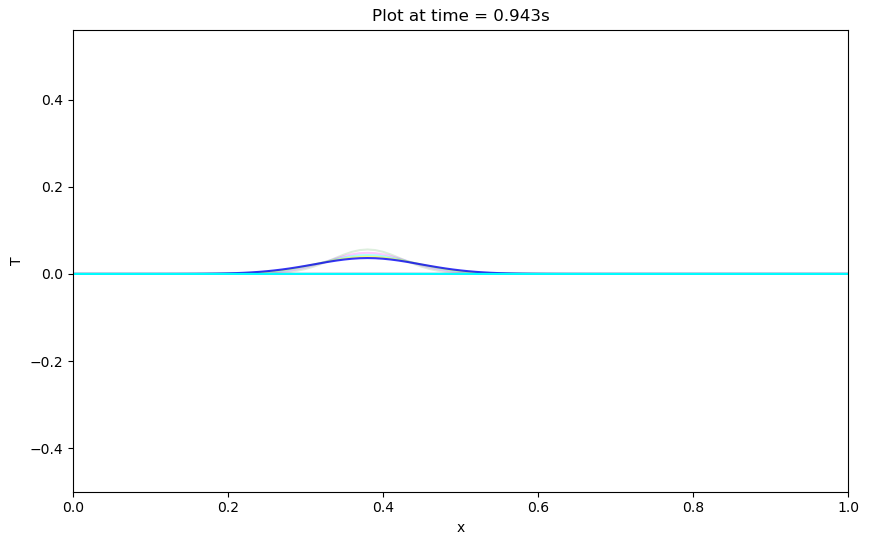

In [8]:
steps = 10
t_min_plot = .25            # default = 0
t_max_plot = T         # default = len(U_7)
x_min_plot = 0            # default = 0
x_max_plot = L           # default = t_max
PDE.PDE_plotter_1D(u, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .8)

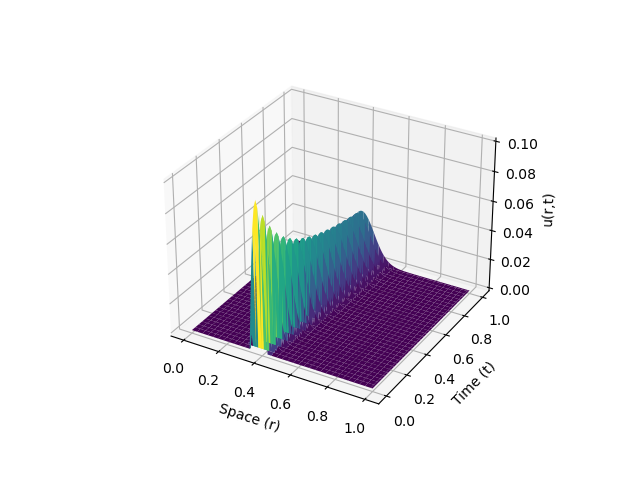

In [9]:
R, T = np.meshgrid(r, t)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(R, T, u, cmap='viridis')
ax.set_xlabel('Space (r)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('u(r,t)')
plt.show()